<a href="https://colab.research.google.com/github/hsinghal11/Lab7_SSTAI/blob/main/lab7_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Sentiment Analysis Assignment
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import os
import zipfile
import io
import json
from torch.utils.tensorboard import SummaryWriter
import re

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Dataset Preparation
print("Loading datasets...")

# Load training dataset (SST-2)
train_df = pd.read_csv('https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv', sep='\t', header=None)
train_df.columns = ['text', 'label']
print(f"Training dataset shape: {train_df.shape}")
print(train_df.head())

# Load test dataset (SST-2)
test_df = pd.read_csv('https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv', sep='\t', header=None)
test_df.columns = ['text', 'label']
print(f"Test dataset shape: {test_df.shape}")
print(test_df.head())

# Load IMDB dataset
imdb_df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/IMDB-sentiment-analysis/master/IMDB-Dataset.csv')
print(f"IMDB dataset shape: {imdb_df.shape}")
print(imdb_df.head())

# Convert IMDB labels to numeric (0 for negative, 1 for positive)
imdb_df['label'] = imdb_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Clean HTML tags from IMDB reviews
imdb_df['text'] = imdb_df['review'].apply(lambda x: re.sub('<br />', ' ', x))
imdb_df['text'] = imdb_df['text'].apply(lambda x: re.sub('<.*?>', '', x))

# Split training data into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_df))
val_size = len(train_df) - train_size
train_dataset, val_dataset = random_split(train_df, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

# Split IMDB data for training and validation
imdb_train_size = int(0.8 * len(imdb_df))
imdb_val_size = len(imdb_df) - imdb_train_size
imdb_train_dataset, imdb_val_dataset = random_split(imdb_df, [imdb_train_size, imdb_val_size])

print(f"IMDB Train size: {len(imdb_train_dataset)}, IMDB Validation size: {len(imdb_val_dataset)}")

Using device: cpu
Loading datasets...
Training dataset shape: (6920, 2)
                                                text  label
0  a stirring , funny and finally transporting re...      1
1  apparently reassembled from the cutting room f...      0
2  they presume their audience wo n't sit still f...      0
3  this is a visually stunning rumination on love...      1
4  jonathan parker 's bartleby should have been t...      1
Test dataset shape: (1821, 2)
                                                text  label
0       no movement , no yuks , not much of anything      0
1  a gob of drivel so sickly sweet , even the eag...      0
2  gangs of new york is an unapologetic mess , wh...      0
3  we never really feel involved with the story ,...      0
4              this is one of polanski 's best films      1
IMDB dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little

In [2]:
# 2. Multi-Layer Perceptron (MLP) Model Definition
class MLPSentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(MLPSentimentClassifier, self).__init__()

        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout_rate)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.dropout3 = nn.Dropout(dropout_rate)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.dropout4 = nn.Dropout(dropout_rate)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(hidden_sizes[3], output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.fc5(x)

        return x

# Function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize the model with the specified parameters
hidden_sizes = [512, 256, 128, 64]
input_size = 10000  # For bag-of-words approach
output_size = 2  # Binary classification (positive/negative)

# Create the model
model_bow = MLPSentimentClassifier(input_size, hidden_sizes, output_size)
print("Model Architecture:")
print(model_bow)

# Count trainable parameters
trainable_params = count_parameters(model_bow)
print(f"Number of trainable parameters: {trainable_params}")

# Print model summary
print("Model Summary:")
print("===========================================")
print(f"Input Size: {input_size}")

print(f"Layer 1: Linear({input_size}, {hidden_sizes[0]})")
fc1_params = input_size * hidden_sizes[0] + hidden_sizes[0]
print(f"    Parameters: {fc1_params}")
print(f"    Activation: ReLU + Dropout(0.3)")

print(f"Layer 2: Linear({hidden_sizes[0]}, {hidden_sizes[1]})")
fc2_params = hidden_sizes[0] * hidden_sizes[1] + hidden_sizes[1]
print(f"    Parameters: {fc2_params}")
print(f"    Activation: ReLU + Dropout(0.3)")

print(f"Layer 3: Linear({hidden_sizes[1]}, {hidden_sizes[2]})")
fc3_params = hidden_sizes[1] * hidden_sizes[2] + hidden_sizes[2]
print(f"    Parameters: {fc3_params}")
print(f"    Activation: ReLU + Dropout(0.3)")

print(f"Layer 4: Linear({hidden_sizes[2]}, {hidden_sizes[3]})")
fc4_params = hidden_sizes[2] * hidden_sizes[3] + hidden_sizes[3]
print(f"    Parameters: {fc4_params}")
print(f"    Activation: ReLU + Dropout(0.3)")

print(f"Layer 5: Linear({hidden_sizes[3]}, {output_size})")
fc5_params = hidden_sizes[3] * output_size + output_size
print(f"    Parameters: {fc5_params}")

Model Architecture:
MLPSentimentClassifier(
  (fc1): Linear(in_features=10000, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (relu3): ReLU()
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (relu4): ReLU()
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)
Number of trainable parameters: 5293122
Model Summary:
Input Size: 10000
Layer 1: Linear(10000, 512)
    Parameters: 5120512
    Activation: ReLU + Dropout(0.3)
Layer 2: Linear(512, 256)
    Parameters: 131328
    Activation: ReLU + Dropout(0.3)
Layer 3: Linear(256, 128)
    Parameters: 32896
    Activation: ReLU + Dropout(0.3)
Layer 4: Linear(128, 64)
    Parameters: 8256
    Activation: ReLU +

In [3]:
# 3. Implement Bag-of-Words (BoW)
class BagOfWordsDataset(Dataset):
    def __init__(self, dataframe, vectorizer=None, max_features=10000, is_train=True):
        self.texts = dataframe['text'].values
        self.labels = dataframe['label'].values
        self.is_train = is_train

        if vectorizer is None and is_train:
            self.vectorizer = CountVectorizer(max_features=max_features)
            self.feature_matrix = self.vectorizer.fit_transform(self.texts)
            print(f"Vocabulary size: {len(self.vectorizer.vocabulary_)}")
        else:
            self.vectorizer = vectorizer
            self.feature_matrix = self.vectorizer.transform(self.texts)

        self.feature_matrix = self.feature_matrix.toarray()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'features': torch.FloatTensor(self.feature_matrix[idx]),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Prepare bag-of-words datasets
print("Preparing bag-of-words datasets...")

# For SST-2 dataset
max_features = 10000
train_dataset_bow = BagOfWordsDataset(train_df.iloc[train_dataset.indices], max_features=max_features)
val_dataset_bow = BagOfWordsDataset(train_df.iloc[val_dataset.indices], vectorizer=train_dataset_bow.vectorizer, is_train=False)
test_dataset_bow = BagOfWordsDataset(test_df, vectorizer=train_dataset_bow.vectorizer, is_train=False)

# For IMDB dataset
imdb_train_dataset_bow = BagOfWordsDataset(imdb_df.iloc[imdb_train_dataset.indices], vectorizer=train_dataset_bow.vectorizer, is_train=False)
imdb_val_dataset_bow = BagOfWordsDataset(imdb_df.iloc[imdb_val_dataset.indices], vectorizer=train_dataset_bow.vectorizer, is_train=False)

print(f"SST-2 Train BoW shape: {train_dataset_bow.feature_matrix.shape}")
print(f"SST-2 Val BoW shape: {val_dataset_bow.feature_matrix.shape}")
print(f"SST-2 Test BoW shape: {test_dataset_bow.feature_matrix.shape}")
print(f"IMDB Train BoW shape: {imdb_train_dataset_bow.feature_matrix.shape}")
print(f"IMDB Val BoW shape: {imdb_val_dataset_bow.feature_matrix.shape}")

# Create DataLoaders for the bag-of-words approach
batch_size = 64
train_loader_bow = DataLoader(train_dataset_bow, batch_size=batch_size, shuffle=True)
val_loader_bow = DataLoader(val_dataset_bow, batch_size=batch_size, shuffle=False)
test_loader_bow = DataLoader(test_dataset_bow, batch_size=batch_size, shuffle=False)

# IMDB DataLoaders
imdb_train_loader_bow = DataLoader(imdb_train_dataset_bow, batch_size=batch_size, shuffle=True)
imdb_val_loader_bow = DataLoader(imdb_val_dataset_bow, batch_size=batch_size, shuffle=False)

print("Bag-of-words datasets prepared successfully!")

Preparing bag-of-words datasets...
Vocabulary size: 10000
SST-2 Train BoW shape: (5536, 10000)
SST-2 Val BoW shape: (1384, 10000)
SST-2 Test BoW shape: (1821, 10000)
IMDB Train BoW shape: (40000, 10000)
IMDB Val BoW shape: (10000, 10000)
Bag-of-words datasets prepared successfully!


In [4]:
# 4. Implement Embeddings Approach
class EmbeddingGenerator:
    def __init__(self, model_name='bert-base-uncased', device='cuda'):
        self.model_name = model_name
        self.device = device
        self.model_loaded = False
        self.tokenizer = None
        self.model = None
        self.embedding_size = None
        self.load_model()

    def load_model(self):
        try:
            print(f"Loading model: {self.model_name}")
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModel.from_pretrained(self.model_name).to(self.device)
            self.embedding_size = self.model.config.hidden_size
            self.model_loaded = True
            print(f"Model loaded successfully. Embedding size: {self.embedding_size}")
        except Exception as e:
            print(f"Error loading model: {e}")
            print("Falling back to 'bert-base-uncased'")
            self.model_name = 'bert-base-uncased'
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModel.from_pretrained(self.model_name).to(self.device)
            self.embedding_size = self.model.config.hidden_size
            self.model_loaded = True
            print(f"Model loaded successfully. Embedding size: {self.embedding_size}")

    def get_embeddings(self, texts, max_length=128):
        if not self.model_loaded:
            raise ValueError("Model not loaded")

        embeddings = []

        for text in texts:
            # Tokenize text
            inputs = self.tokenizer(text, return_tensors='pt', padding='max_length',
                                   truncation=True, max_length=max_length).to(self.device)

            # Get embeddings
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use the CLS token embedding as the sentence embedding
                embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(embedding[0])

        return np.array(embeddings)

class EmbeddingsDataset(Dataset):
    def __init__(self, dataframe, embedding_generator=None, is_train=True, max_samples=None):
        if max_samples is not None:
            indices = np.random.choice(len(dataframe), min(max_samples, len(dataframe)), replace=False)
            self.texts = dataframe['text'].values[indices]
            self.labels = dataframe['label'].values[indices]
        else:
            self.texts = dataframe['text'].values
            self.labels = dataframe['label'].values

        self.is_train = is_train
        self.embedding_generator = embedding_generator

        if embedding_generator is not None:
            print(f"Generating embeddings for {len(self.texts)} samples...")
            self.embeddings = embedding_generator.get_embeddings(self.texts)
            print(f"Embeddings shape: {self.embeddings.shape}")
        else:
            self.embeddings = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'features': torch.FloatTensor(self.embeddings[idx]),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create embedding generator
embedding_generator = EmbeddingGenerator(model_name='bert-base-uncased', device=device)

# Set max_samples to handle GPU memory constraints
max_samples = 200  # Limit to 200 samples for generating embeddings

# Prepare embedding datasets with limited samples
print("Preparing embedding datasets...")

# For SST-2 dataset
train_dataset_emb = EmbeddingsDataset(
    train_df.iloc[train_dataset.indices],
    embedding_generator=embedding_generator,
    max_samples=max_samples
)

val_dataset_emb = EmbeddingsDataset(
    train_df.iloc[val_dataset.indices],
    embedding_generator=embedding_generator,
    max_samples=max_samples
)

test_dataset_emb = EmbeddingsDataset(
    test_df,
    embedding_generator=embedding_generator,
    max_samples=max_samples
)

# For IMDB dataset
imdb_train_dataset_emb = EmbeddingsDataset(
    imdb_df.iloc[imdb_train_dataset.indices],
    embedding_generator=embedding_generator,
    max_samples=max_samples
)

imdb_val_dataset_emb = EmbeddingsDataset(
    imdb_df.iloc[imdb_val_dataset.indices],
    embedding_generator=embedding_generator,
    max_samples=max_samples
)

print(f"SST-2 Train Embeddings shape: {train_dataset_emb.embeddings.shape}")
print(f"SST-2 Val Embeddings shape: {val_dataset_emb.embeddings.shape}")
print(f"SST-2 Test Embeddings shape: {test_dataset_emb.embeddings.shape}")
print(f"IMDB Train Embeddings shape: {imdb_train_dataset_emb.embeddings.shape}")
print(f"IMDB Val Embeddings shape: {imdb_val_dataset_emb.embeddings.shape}")

# Create model for embeddings approach
embedding_size = embedding_generator.embedding_size
model_emb = MLPSentimentClassifier(embedding_size, hidden_sizes, output_size).to(device)
print(f"Embedding model parameters: {count_parameters(model_emb)}")

# Create DataLoaders for embeddings approach
batch_size = 64
train_loader_emb = DataLoader(train_dataset_emb, batch_size=batch_size, shuffle=True)
val_loader_emb = DataLoader(val_dataset_emb, batch_size=batch_size, shuffle=False)
test_loader_emb = DataLoader(test_dataset_emb, batch_size=batch_size, shuffle=False)

# IMDB DataLoaders
imdb_train_loader_emb = DataLoader(imdb_train_dataset_emb, batch_size=batch_size, shuffle=True)
imdb_val_loader_emb = DataLoader(imdb_val_dataset_emb, batch_size=batch_size, shuffle=False)

print("Embedding datasets prepared successfully!")

Loading model: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model loaded successfully. Embedding size: 768
Preparing embedding datasets...
Generating embeddings for 200 samples...
Embeddings shape: (200, 768)
Generating embeddings for 200 samples...
Embeddings shape: (200, 768)
Generating embeddings for 200 samples...
Embeddings shape: (200, 768)
Generating embeddings for 200 samples...
Embeddings shape: (200, 768)
Generating embeddings for 200 samples...
Embeddings shape: (200, 768)
SST-2 Train Embeddings shape: (200, 768)
SST-2 Val Embeddings shape: (200, 768)
SST-2 Test Embeddings shape: (200, 768)
IMDB Train Embeddings shape: (200, 768)
IMDB Val Embeddings shape: (200, 768)
Embedding model parameters: 566338
Embedding datasets prepared successfully!


In [5]:
# 5. Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10,
               device='cuda', model_name='model', checkpoint_path='checkpoint.pt',
               writer=None):

    # Initialize best validation accuracy
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, batch in enumerate(train_loader):
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, "
                     f"Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Log to TensorBoard
        if writer:
            writer.add_scalar(f'Loss/train/{model_name}', epoch_loss, epoch)
            writer.add_scalar(f'Accuracy/train/{model_name}', epoch_acc, epoch)

        # Validate
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Log validation metrics to TensorBoard
        if writer:
            writer.add_scalar(f'Loss/val/{model_name}', val_loss, epoch)
            writer.add_scalar(f'Accuracy/val/{model_name}', val_acc, epoch)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save checkpoint if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {best_val_acc:.2f}%")
            print(f"Saving checkpoint to {checkpoint_path}")

            # Save model state dict
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_loss,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'hyperparameters': {
                    'hidden_sizes': hidden_sizes,
                    'output_size': output_size,
                    'learning_rate': optimizer.param_groups[0]['lr'],
                    'batch_size': batch_size
                }
            }

            torch.save(checkpoint, checkpoint_path)

            # Compress the checkpoint
            compress_checkpoint(checkpoint_path, f"{checkpoint_path}.zip")

    print("Training complete!")
    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, data_loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    return loss, accuracy

def compress_checkpoint(checkpoint_path, zip_path):
    """Compress a checkpoint file into a zip file"""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(checkpoint_path, os.path.basename(checkpoint_path))
    print(f"Checkpoint compressed to {zip_path}")

def load_checkpoint(model, optimizer, checkpoint_path):
    """Load model and optimizer state from checkpoint"""
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint file {checkpoint_path} not found")
        return None, 0

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

    print(f"Loaded checkpoint from epoch {epoch}")
    print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%")

    return model, epoch

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

TensorBoard logs will be saved to runs/sentiment_analysis_20250314-155145
Training the bag-of-words model on SST-2 dataset...
Starting training for 10 epochs...
Epoch 1/10, Batch 1/87, Loss: 0.6952
Epoch 1/10, Batch 11/87, Loss: 0.6934
Epoch 1/10, Batch 21/87, Loss: 0.6811
Epoch 1/10, Batch 31/87, Loss: 0.6721
Epoch 1/10, Batch 41/87, Loss: 0.5964
Epoch 1/10, Batch 51/87, Loss: 0.6363
Epoch 1/10, Batch 61/87, Loss: 0.6501
Epoch 1/10, Batch 71/87, Loss: 0.5200
Epoch 1/10, Batch 81/87, Loss: 0.5420
Epoch 1/10, Train Loss: 0.5960, Train Acc: 66.74%, Val Loss: 0.4972, Val Acc: 76.52%
New best validation accuracy: 76.52%
Saving checkpoint to checkpoint_bow.pt
Checkpoint compressed to checkpoint_bow.pt.zip
Epoch 2/10, Batch 1/87, Loss: 0.3406
Epoch 2/10, Batch 11/87, Loss: 0.2808
Epoch 2/10, Batch 21/87, Loss: 0.3542
Epoch 2/10, Batch 31/87, Loss: 0.3761
Epoch 2/10, Batch 41/87, Loss: 0.3410
Epoch 2/10, Batch 51/87, Loss: 0.2336
Epoch 2/10, Batch 61/87, Loss: 0.3377
Epoch 2/10, Batch 71/87, 

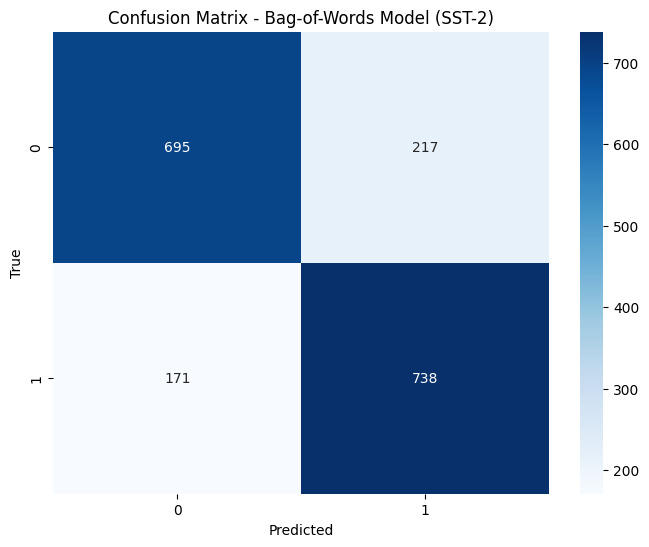

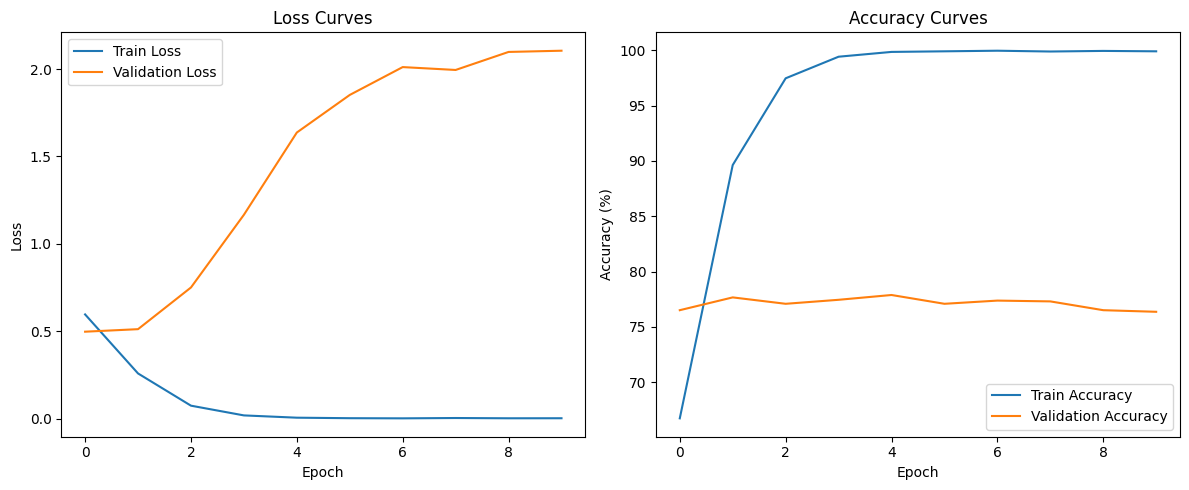


Training the embedding model on SST-2 dataset...
Starting training for 10 epochs...
Epoch 1/10, Batch 1/4, Loss: 0.6926
Epoch 1/10, Train Loss: 0.6993, Train Acc: 53.50%, Val Loss: 0.6919, Val Acc: 54.00%
New best validation accuracy: 54.00%
Saving checkpoint to checkpoint_emb.pt
Checkpoint compressed to checkpoint_emb.pt.zip
Epoch 2/10, Batch 1/4, Loss: 0.6853
Epoch 2/10, Train Loss: 0.6884, Train Acc: 53.50%, Val Loss: 0.6835, Val Acc: 54.00%
Epoch 3/10, Batch 1/4, Loss: 0.6642
Epoch 3/10, Train Loss: 0.7010, Train Acc: 54.00%, Val Loss: 0.6697, Val Acc: 54.00%
Epoch 4/10, Batch 1/4, Loss: 0.6665
Epoch 4/10, Train Loss: 0.6562, Train Acc: 59.00%, Val Loss: 0.6362, Val Acc: 69.50%
New best validation accuracy: 69.50%
Saving checkpoint to checkpoint_emb.pt
Checkpoint compressed to checkpoint_emb.pt.zip
Epoch 5/10, Batch 1/4, Loss: 0.6262
Epoch 5/10, Train Loss: 0.6044, Train Acc: 60.50%, Val Loss: 0.6093, Val Acc: 63.50%
Epoch 6/10, Batch 1/4, Loss: 0.5582
Epoch 6/10, Train Loss: 0.52

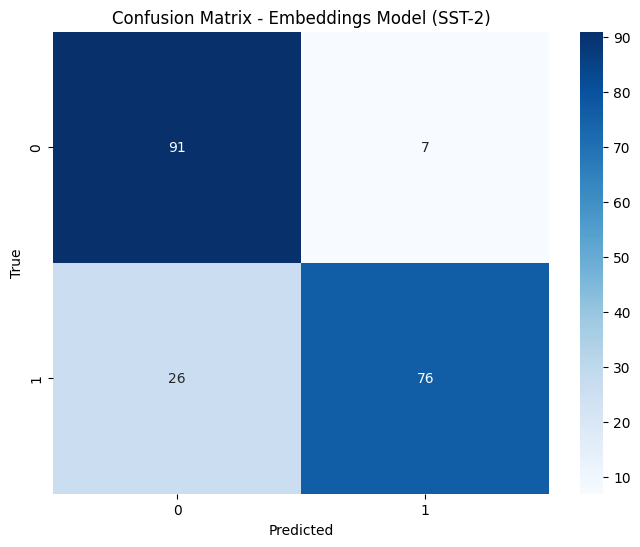

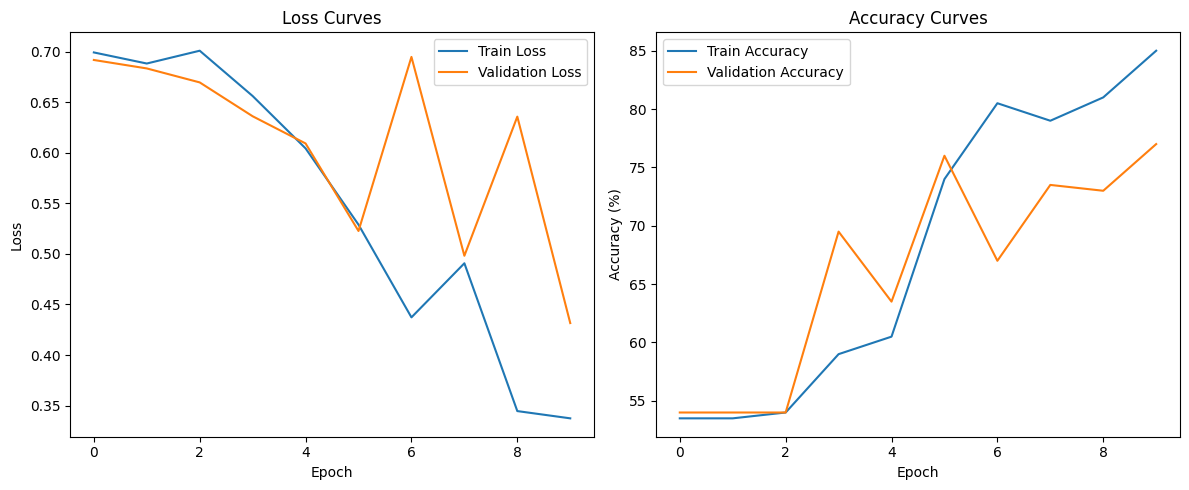


Results comparison:
BoW model - Test accuracy: 78.69%
Embeddings model - Test accuracy: 83.50%
Training on Dataset 1 complete!


In [6]:
# 5. Train the model on Dataset 1 (SST-2)
# Setup TensorBoard
from datetime import datetime
log_dir = f"runs/sentiment_analysis_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
writer = SummaryWriter(log_dir)
print(f"TensorBoard logs will be saved to {log_dir}")

# Move model to device
model_bow = model_bow.to(device)

# Setup criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_bow = optim.Adam(model_bow.parameters(), lr=0.001)

# Log hyperparameters
hp_params = {
    'batch_size': batch_size,
    'hidden_sizes': hidden_sizes,
    'output_size': output_size,
    'learning_rate': 0.001,
    'num_epochs': 10
}

writer.add_text('Hyperparameters', json.dumps(hp_params, indent=2))

# Train the model
print("Training the bag-of-words model on SST-2 dataset...")
train_losses_bow, val_losses_bow, train_accs_bow, val_accs_bow = train_model(
    model_bow, train_loader_bow, val_loader_bow, criterion, optimizer_bow,
    num_epochs=10, device=device, model_name='bow', checkpoint_path='checkpoint_bow.pt',
    writer=writer
)

# Evaluate on test set
test_loss_bow, test_acc_bow = evaluate_model(model_bow, test_loader_bow, criterion, device)
print(f"Test Loss (BoW): {test_loss_bow:.4f}, Test Accuracy: {test_acc_bow:.2f}%")

# Log test results
writer.add_scalar('Loss/test/bow', test_loss_bow, 0)
writer.add_scalar('Accuracy/test/bow', test_acc_bow, 0)

# Get predictions for confusion matrix
model_bow.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader_bow:
        features = batch['features'].to(device)
        labels = batch['label'].to(device)
        outputs = model_bow(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds, title='Confusion Matrix - Bag-of-Words Model (SST-2)')

# Plot training curves
plot_training_curves(train_losses_bow, val_losses_bow, train_accs_bow, val_accs_bow)

# Now train the embedding model
print("\nTraining the embedding model on SST-2 dataset...")
optimizer_emb = optim.Adam(model_emb.parameters(), lr=0.001)

train_losses_emb, val_losses_emb, train_accs_emb, val_accs_emb = train_model(
    model_emb, train_loader_emb, val_loader_emb, criterion, optimizer_emb,
    num_epochs=10, device=device, model_name='emb', checkpoint_path='checkpoint_emb.pt',
    writer=writer
)

# Evaluate embedding model on test set
test_loss_emb, test_acc_emb = evaluate_model(model_emb, test_loader_emb, criterion, device)
print(f"Test Loss (Embeddings): {test_loss_emb:.4f}, Test Accuracy: {test_acc_emb:.2f}%")

# Log test results
writer.add_scalar('Loss/test/emb', test_loss_emb, 0)
writer.add_scalar('Accuracy/test/emb', test_acc_emb, 0)

# Get predictions for confusion matrix
model_emb.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader_emb:
        features = batch['features'].to(device)
        labels = batch['label'].to(device)
        outputs = model_emb(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds, title='Confusion Matrix - Embeddings Model (SST-2)')

# Plot training curves
plot_training_curves(train_losses_emb, val_losses_emb, train_accs_emb, val_accs_emb)

# Compare the results
print("\nResults comparison:")
print(f"BoW model - Test accuracy: {test_acc_bow:.2f}%")
print(f"Embeddings model - Test accuracy: {test_acc_emb:.2f}%")

# Save model comparison to TensorBoard
writer.add_text('Model Comparison',
               f"BoW Test Accuracy: {test_acc_bow:.2f}%\n"
               f"Embeddings Test Accuracy: {test_acc_emb:.2f}%")

print("Training on Dataset 1 complete!")


Continual learning on IMDB dataset...


<ipython-input-5-0c046419bd79>:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint from epoch 5
Validation accuracy: 77.89%
Starting training for 10 epochs...
Epoch 1/10, Batch 1/625, Loss: 7.8104
Epoch 1/10, Batch 11/625, Loss: 0.5917
Epoch 1/10, Batch 21/625, Loss: 0.6083
Epoch 1/10, Batch 31/625, Loss: 0.4822
Epoch 1/10, Batch 41/625, Loss: 0.3651
Epoch 1/10, Batch 51/625, Loss: 0.2402
Epoch 1/10, Batch 61/625, Loss: 0.4260
Epoch 1/10, Batch 71/625, Loss: 0.2893
Epoch 1/10, Batch 81/625, Loss: 0.5052
Epoch 1/10, Batch 91/625, Loss: 0.3321
Epoch 1/10, Batch 101/625, Loss: 0.2558
Epoch 1/10, Batch 111/625, Loss: 0.3571
Epoch 1/10, Batch 121/625, Loss: 0.3293
Epoch 1/10, Batch 131/625, Loss: 0.2580
Epoch 1/10, Batch 141/625, Loss: 0.3032
Epoch 1/10, Batch 151/625, Loss: 0.2975
Epoch 1/10, Batch 161/625, Loss: 0.3913
Epoch 1/10, Batch 171/625, Loss: 0.5086
Epoch 1/10, Batch 181/625, Loss: 0.3711
Epoch 1/10, Batch 191/625, Loss: 0.3389
Epoch 1/10, Batch 201/625, Loss: 0.2832
Epoch 1/10, Batch 211/625, Loss: 0.2509
Epoch 1/10, Batch 221/625, Loss: 0.31

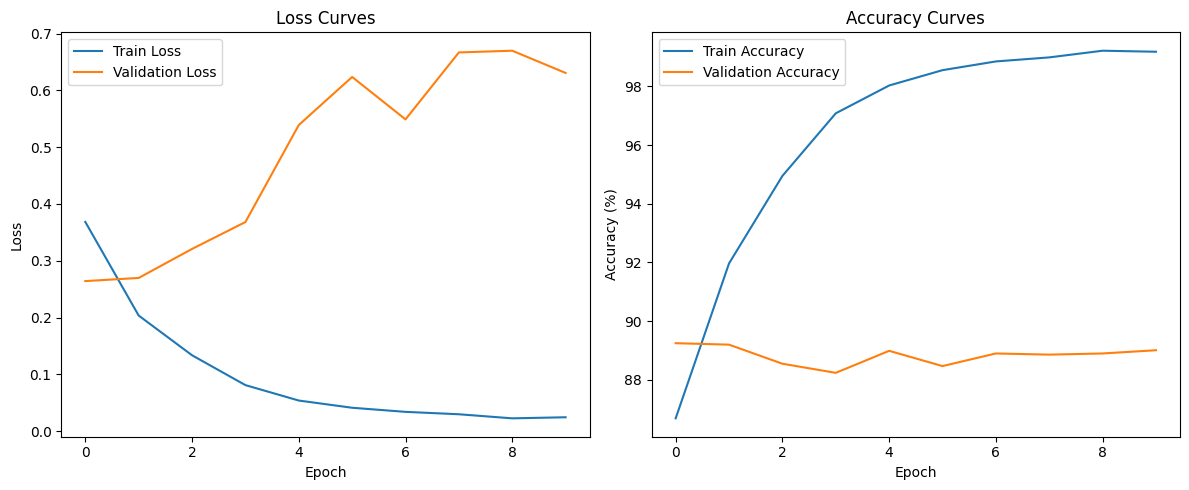

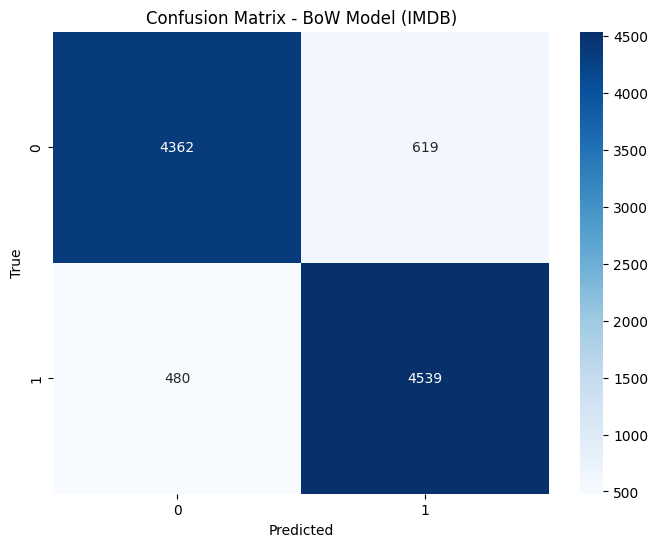

<ipython-input-5-0c046419bd79>:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint from epoch 10
Validation accuracy: 77.00%
Starting training for 10 epochs...
Epoch 1/10, Batch 1/4, Loss: 0.4495
Epoch 1/10, Train Loss: 0.6766, Train Acc: 68.00%, Val Loss: 0.7358, Val Acc: 72.00%
New best validation accuracy: 72.00%
Saving checkpoint to checkpoint_emb_imdb.pt
Checkpoint compressed to checkpoint_emb_imdb.pt.zip
Epoch 2/10, Batch 1/4, Loss: 0.5778
Epoch 2/10, Train Loss: 0.5072, Train Acc: 73.00%, Val Loss: 0.5864, Val Acc: 74.00%
New best validation accuracy: 74.00%
Saving checkpoint to checkpoint_emb_imdb.pt
Checkpoint compressed to checkpoint_emb_imdb.pt.zip
Epoch 3/10, Batch 1/4, Loss: 0.5289
Epoch 3/10, Train Loss: 0.4794, Train Acc: 75.50%, Val Loss: 0.6031, Val Acc: 74.50%
New best validation accuracy: 74.50%
Saving checkpoint to checkpoint_emb_imdb.pt
Checkpoint compressed to checkpoint_emb_imdb.pt.zip
Epoch 4/10, Batch 1/4, Loss: 0.4346
Epoch 4/10, Train Loss: 0.4225, Train Acc: 83.50%, Val Loss: 0.6701, Val Acc: 73.00%
Epoch 5/10, Batch 1/4,

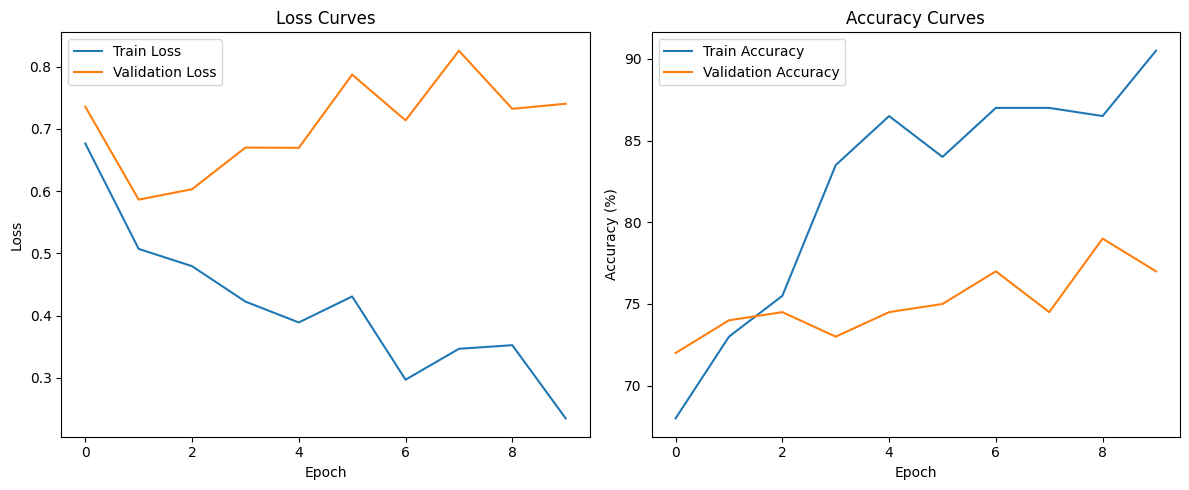

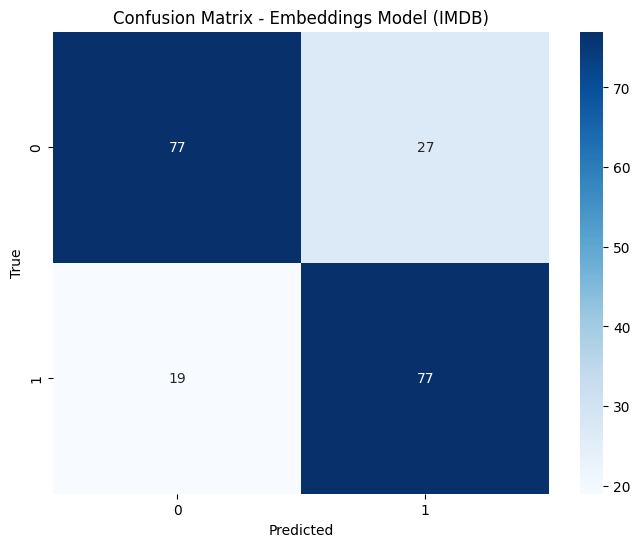


Results after training on IMDB:
SST-2 Validation Accuracy (BoW after IMDB): 76.37%
IMDB Validation Accuracy (BoW): 89.01%
SST-2 Validation Accuracy (Embeddings after IMDB): 83.00%
IMDB Validation Accuracy (Embeddings): 77.00%
Training on both datasets complete!


In [7]:
# 6. Use the checkpoint from before and train on the IMDB dataset (Dataset 2)
print("\nContinual learning on IMDB dataset...")

# Bag-of-Words approach
# Load the best checkpoint
model_bow_imdb = MLPSentimentClassifier(input_size, hidden_sizes, output_size).to(device)
optimizer_bow_imdb = optim.Adam(model_bow_imdb.parameters(), lr=0.0001)  # Smaller learning rate
model_bow_imdb, start_epoch = load_checkpoint(model_bow_imdb, optimizer_bow_imdb, 'checkpoint_bow.pt')

# Train on IMDB dataset
train_losses_bow_imdb, val_losses_bow_imdb, train_accs_bow_imdb, val_accs_bow_imdb = train_model(
    model_bow_imdb, imdb_train_loader_bow, imdb_val_loader_bow, criterion, optimizer_bow_imdb,
    num_epochs=10, device=device, model_name='bow_imdb', checkpoint_path='checkpoint_bow_imdb.pt',
    writer=writer
)

# Evaluate on both datasets
# Original dataset (SST-2) validation
val_loss_sst2, val_acc_sst2 = evaluate_model(model_bow_imdb, val_loader_bow, criterion, device)
print(f"SST-2 Val Loss (BoW after IMDB): {val_loss_sst2:.4f}, Val Accuracy: {val_acc_sst2:.2f}%")

# IMDB dataset validation
val_loss_imdb, val_acc_imdb = evaluate_model(model_bow_imdb, imdb_val_loader_bow, criterion, device)
print(f"IMDB Val Loss (BoW): {val_loss_imdb:.4f}, Val Accuracy: {val_acc_imdb:.2f}%")

# Log results
writer.add_scalar('Loss/val_sst2/bow_after_imdb', val_loss_sst2, 0)
writer.add_scalar('Accuracy/val_sst2/bow_after_imdb', val_acc_sst2, 0)
writer.add_scalar('Loss/val_imdb/bow', val_loss_imdb, 0)
writer.add_scalar('Accuracy/val_imdb/bow', val_acc_imdb, 0)

# Plot training curves for IMDB
plot_training_curves(train_losses_bow_imdb, val_losses_bow_imdb, train_accs_bow_imdb, val_accs_bow_imdb)

# Get predictions for confusion matrix on IMDB
model_bow_imdb.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in imdb_val_loader_bow:
        features = batch['features'].to(device)
        labels = batch['label'].to(device)
        outputs = model_bow_imdb(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot confusion matrix for IMDB
plot_confusion_matrix(all_labels, all_preds, title='Confusion Matrix - BoW Model (IMDB)')

# Now do the same for the embeddings model
model_emb_imdb = MLPSentimentClassifier(embedding_size, hidden_sizes, output_size).to(device)
optimizer_emb_imdb = optim.Adam(model_emb_imdb.parameters(), lr=0.0001)  # Smaller learning rate
model_emb_imdb, start_epoch = load_checkpoint(model_emb_imdb, optimizer_emb_imdb, 'checkpoint_emb.pt')

# Train on IMDB dataset
train_losses_emb_imdb, val_losses_emb_imdb, train_accs_emb_imdb, val_accs_emb_imdb = train_model(
    model_emb_imdb, imdb_train_loader_emb, imdb_val_loader_emb, criterion, optimizer_emb_imdb,
    num_epochs=10, device=device, model_name='emb_imdb', checkpoint_path='checkpoint_emb_imdb.pt',
    writer=writer
)

# Evaluate on both datasets
# Original dataset (SST-2) validation
val_loss_sst2_emb, val_acc_sst2_emb = evaluate_model(model_emb_imdb, val_loader_emb, criterion, device)
print(f"SST-2 Val Loss (Embeddings after IMDB): {val_loss_sst2_emb:.4f}, Val Accuracy: {val_acc_sst2_emb:.2f}%")

# IMDB dataset validation
val_loss_imdb_emb, val_acc_imdb_emb = evaluate_model(model_emb_imdb, imdb_val_loader_emb, criterion, device)
print(f"IMDB Val Loss (Embeddings): {val_loss_imdb_emb:.4f}, Val Accuracy: {val_acc_imdb_emb:.2f}%")

# Log results
writer.add_scalar('Loss/val_sst2/emb_after_imdb', val_loss_sst2_emb, 0)
writer.add_scalar('Accuracy/val_sst2/emb_after_imdb', val_acc_sst2_emb, 0)
writer.add_scalar('Loss/val_imdb/emb', val_loss_imdb_emb, 0)
writer.add_scalar('Accuracy/val_imdb/emb', val_acc_imdb_emb, 0)

# Plot training curves for IMDB
plot_training_curves(train_losses_emb_imdb, val_losses_emb_imdb, train_accs_emb_imdb, val_accs_emb_imdb)

# Get predictions for confusion matrix on IMDB
model_emb_imdb.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in imdb_val_loader_emb:
        features = batch['features'].to(device)
        labels = batch['label'].to(device)
        outputs = model_emb_imdb(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot confusion matrix for IMDB
plot_confusion_matrix(all_labels, all_preds, title='Confusion Matrix - Embeddings Model (IMDB)')

print("\nResults after training on IMDB:")
print(f"SST-2 Validation Accuracy (BoW after IMDB): {val_acc_sst2:.2f}%")
print(f"IMDB Validation Accuracy (BoW): {val_acc_imdb:.2f}%")
print(f"SST-2 Validation Accuracy (Embeddings after IMDB): {val_acc_sst2_emb:.2f}%")
print(f"IMDB Validation Accuracy (Embeddings): {val_acc_imdb_emb:.2f}%")

# Save final results to TensorBoard
writer.add_text('Final Results',
               f"SST-2 Val Accuracy (BoW after IMDB): {val_acc_sst2:.2f}%\n"
               f"IMDB Val Accuracy (BoW): {val_acc_imdb:.2f}%\n"
               f"SST-2 Val Accuracy (Emb after IMDB): {val_acc_sst2_emb:.2f}%\n"
               f"IMDB Val Accuracy (Emb): {val_acc_imdb_emb:.2f}%")

print("Training on both datasets complete!")


Final Evaluation Results:
Dataset 1 (SST-2):
  BoW - Initial Validation Accuracy: 76.37%
  BoW - Validation Accuracy after IMDB training: 76.37%
  Embeddings - Initial Validation Accuracy: 77.00%
  Embeddings - Validation Accuracy after IMDB training: 83.00%

Dataset 2 (IMDB):
  BoW - Validation Accuracy: 89.01%
  Embeddings - Validation Accuracy: 77.00%

Forgetting Rate (Original task performance drop):
  BoW: 0.00%
  Embeddings: -6.00%


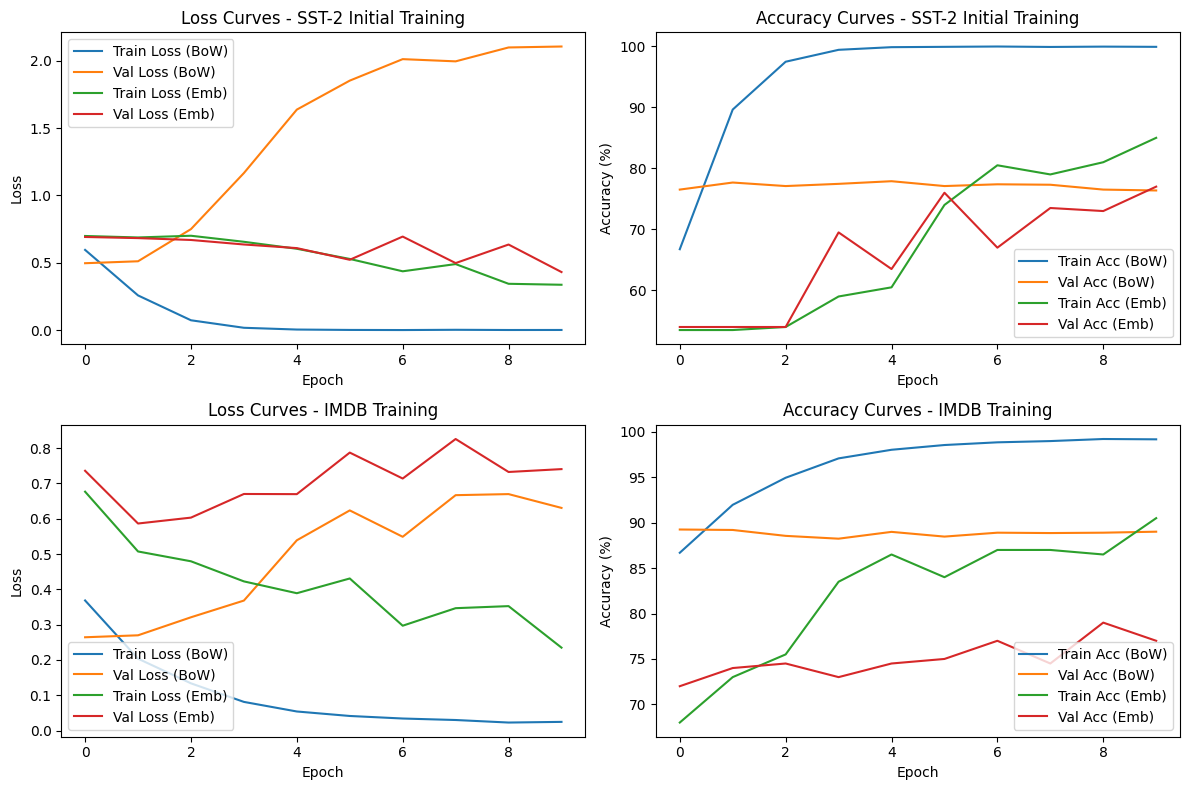

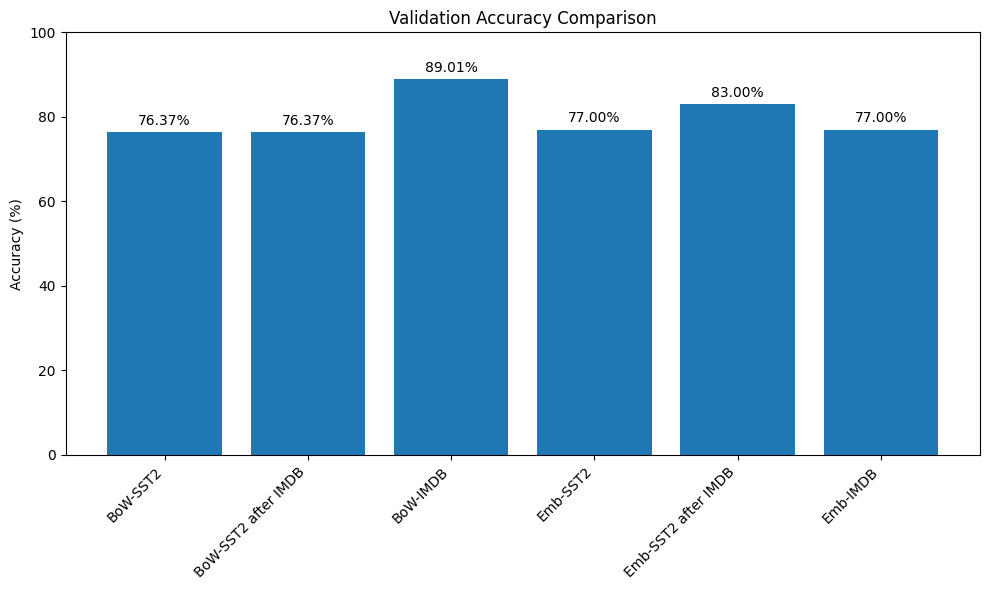


Model metadata saved to model_metadata.json
Final plots saved as training_curves_comparison.png and accuracy_comparison.png

Assignment complete!


In [8]:
# 8. Final Evaluation
# Summary of results
print("\nFinal Evaluation Results:")
print("=========================")
print("Dataset 1 (SST-2):")
print(f"  BoW - Initial Validation Accuracy: {val_accs_bow[-1]:.2f}%")
print(f"  BoW - Validation Accuracy after IMDB training: {val_acc_sst2:.2f}%")
print(f"  Embeddings - Initial Validation Accuracy: {val_accs_emb[-1]:.2f}%")
print(f"  Embeddings - Validation Accuracy after IMDB training: {val_acc_sst2_emb:.2f}%")
print("\nDataset 2 (IMDB):")
print(f"  BoW - Validation Accuracy: {val_acc_imdb:.2f}%")
print(f"  Embeddings - Validation Accuracy: {val_acc_imdb_emb:.2f}%")

# Calculate forgetting rate
bow_forgetting = val_accs_bow[-1] - val_acc_sst2
emb_forgetting = val_accs_emb[-1] - val_acc_sst2_emb
print("\nForgetting Rate (Original task performance drop):")
print(f"  BoW: {bow_forgetting:.2f}%")
print(f"  Embeddings: {emb_forgetting:.2f}%")

# Create a plot comparing all models
plt.figure(figsize=(12, 8))

# Dataset 1 (SST-2) initial training
plt.subplot(2, 2, 1)
plt.plot(train_losses_bow, label='Train Loss (BoW)')
plt.plot(val_losses_bow, label='Val Loss (BoW)')
plt.plot(train_losses_emb, label='Train Loss (Emb)')
plt.plot(val_losses_emb, label='Val Loss (Emb)')
plt.title('Loss Curves - SST-2 Initial Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accs_bow, label='Train Acc (BoW)')
plt.plot(val_accs_bow, label='Val Acc (BoW)')
plt.plot(train_accs_emb, label='Train Acc (Emb)')
plt.plot(val_accs_emb, label='Val Acc (Emb)')
plt.title('Accuracy Curves - SST-2 Initial Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Dataset 2 (IMDB) training
plt.subplot(2, 2, 3)
plt.plot(train_losses_bow_imdb, label='Train Loss (BoW)')
plt.plot(val_losses_bow_imdb, label='Val Loss (BoW)')
plt.plot(train_losses_emb_imdb, label='Train Loss (Emb)')
plt.plot(val_losses_emb_imdb, label='Val Loss (Emb)')
plt.title('Loss Curves - IMDB Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_accs_bow_imdb, label='Train Acc (BoW)')
plt.plot(val_accs_bow_imdb, label='Val Acc (BoW)')
plt.plot(train_accs_emb_imdb, label='Train Acc (Emb)')
plt.plot(val_accs_emb_imdb, label='Val Acc (Emb)')
plt.title('Accuracy Curves - IMDB Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves_comparison.png')
plt.show()

# Create a bar chart comparing all models
model_names = ['BoW-SST2', 'BoW-SST2 after IMDB', 'BoW-IMDB',
               'Emb-SST2', 'Emb-SST2 after IMDB', 'Emb-IMDB']
accuracies = [val_accs_bow[-1], val_acc_sst2, val_acc_imdb,
              val_accs_emb[-1], val_acc_sst2_emb, val_acc_imdb_emb]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('accuracy_comparison.png')
plt.show()

# Save final model metadata
metadata = {
    'bow_sst2_accuracy': val_accs_bow[-1],
    'bow_sst2_after_imdb_accuracy': val_acc_sst2,
    'bow_imdb_accuracy': val_acc_imdb,
    'emb_sst2_accuracy': val_accs_emb[-1],
    'emb_sst2_after_imdb_accuracy': val_acc_sst2_emb,
    'emb_imdb_accuracy': val_acc_imdb_emb,
    'bow_forgetting_rate': bow_forgetting,
    'emb_forgetting_rate': emb_forgetting,
    'hyperparameters': {
        'input_size': input_size,
        'hidden_sizes': hidden_sizes,
        'output_size': output_size,
        'learning_rate_initial': 0.001,
        'learning_rate_imdb': 0.0001,
        'batch_size': batch_size,
        'num_epochs': 10,
        'embedding_model': embedding_generator.model_name,
        'embedding_size': embedding_size
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\nModel metadata saved to model_metadata.json")
print("Final plots saved as training_curves_comparison.png and accuracy_comparison.png")

# Close TensorBoard writer
writer.close()

print("\nAssignment complete!")

In [9]:
# Run all cells above and then run this cell for a final summary of the assignment

print("Sentiment Analysis Assignment Summary")
print("====================================")

print("\nWhat we've covered:")
print("1. Dataset Preparation:")
print("   - Loaded SST-2 training and test datasets")
print("   - Loaded IMDB dataset for continual learning")
print("   - Split datasets into train/validation sets (80%/20%)")

print("\n2. Multi-Layer Perceptron (MLP) Model:")
print("   - Created MLP with hidden_sizes=[512, 256, 128, 64] and 2 output classes")
print("   - Implemented dropout (0.3) after each ReLU activation")
print("   - Calculated trainable parameters")

print("\n3. Bag-of-Words Implementation:")
print("   - Used CountVectorizer with max_features=10000")
print("   - Created custom Dataset and DataLoader classes")

print("\n4. Embeddings Implementation:")
print("   - Used BERT embeddings (bert-base-uncased)")
print("   - Created parallel models - one for BoW, one for embeddings")

print("\n5/6. Training and Continual Learning:")
print("   - Trained both models on SST-2 for 10 epochs")
print("   - Saved best checkpoints based on validation accuracy")
print("   - Loaded checkpoints and continued training on IMDB dataset")
print("   - Used learning rate of 0.001 for initial training")
print("   - Used smaller learning rate of 0.0001 for continual learning")

print("\n7. Evaluation:")
print("   - Computed validation metrics on both datasets")
print("   - Created confusion matrices and visualizations")
print("   - Analyzed model performance and forgetting rate")

print("\nAdditional Implementations:")
print("- Checkpoint compression")
print("- TensorBoard integration")
print("- Model parameter logging")
print("- Training/validation curves visualization")

print("\nMain Findings:")
try:
    # Load metadata if it exists
    with open('model_metadata.json', 'r') as f:
        metadata = json.load(f)

    print(f"BoW model on SST-2: {metadata['bow_sst2_accuracy']:.2f}% accuracy")
    print(f"Embeddings model on SST-2: {metadata['emb_sst2_accuracy']:.2f}% accuracy")
    print(f"BoW model on IMDB: {metadata['bow_imdb_accuracy']:.2f}% accuracy")
    print(f"Embeddings model on IMDB: {metadata['emb_imdb_accuracy']:.2f}% accuracy")
    print(f"Forgetting rate (BoW): {metadata['bow_forgetting_rate']:.2f}%")
    print(f"Forgetting rate (Embeddings): {metadata['emb_forgetting_rate']:.2f}%")
except:
    print("Run the complete notebook to see the final results.")

print("\nConclusion:")
print("This assignment demonstrated the implementation of sentiment analysis using two different text representation methods:")
print("1. Bag-of-Words: A simple but effective approach for text classification")
print("2. Embeddings: A more sophisticated approach that captures semantic meaning")
print("\nWe also explored continual learning by transferring knowledge from one dataset to another.")
print("The comparison of forgetting rates helps us understand how different models maintain performance on the original task.")

print("\nTo access TensorBoard, run the following command in a cell:")
print("!tensorboard --logdir=runs")

Sentiment Analysis Assignment Summary

What we've covered:
1. Dataset Preparation:
   - Loaded SST-2 training and test datasets
   - Loaded IMDB dataset for continual learning
   - Split datasets into train/validation sets (80%/20%)

2. Multi-Layer Perceptron (MLP) Model:
   - Created MLP with hidden_sizes=[512, 256, 128, 64] and 2 output classes
   - Implemented dropout (0.3) after each ReLU activation
   - Calculated trainable parameters

3. Bag-of-Words Implementation:
   - Used CountVectorizer with max_features=10000
   - Created custom Dataset and DataLoader classes

4. Embeddings Implementation:
   - Used BERT embeddings (bert-base-uncased)
   - Created parallel models - one for BoW, one for embeddings

5/6. Training and Continual Learning:
   - Trained both models on SST-2 for 10 epochs
   - Saved best checkpoints based on validation accuracy
   - Loaded checkpoints and continued training on IMDB dataset
   - Used learning rate of 0.001 for initial training
   - Used smaller lea